In [1]:
from utils import sars2_genome_info, get_parent, add_syn_mut_attribute, add_mut_at_node_attr 
from utils_randomization import get_total_muts_on_tree, get_branch_lengths, randomize_mutations_on_tree_multinomial
from utils_plotting import get_color_palette, convert_linege_names, get_linear_reg_stats
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd
from collections import Counter
from scipy import stats
import requests
import random
import math
import json
import re

/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


## Figure 1: Accumulation of nonsynonymous S1 mutations is correlated with clade success

##### A p-value is assigned to the correlation between logistic growth rate and mutation accumulation by comparing the empirical R-value for this correlation to R-values from 1000 randomized trees.

#### This notebook completes the analysis for Figure 1 C. 

Import the tree and convert to Bio Phylo format. This is a time-resolved phylogeny built from 9544 SARS-CoV-2 genomes sampled between December 2019 and May 15, 2021. The tree can be viewed at https://nextstrain.org/groups/blab/ncov/adaptive-evolution/2021-05-15

In [2]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-05-15.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

Get information about genome position and length of each gene 

In [3]:
reference_gene_locations, reference_gene_codon, gene_lengths_aa = sars2_genome_info()

Add information about synonymous mutations as an attribute of nodes on the tree

In [4]:
tree = add_syn_mut_attribute(tree)

Add the number of mutations that occur at a node as an attribute of that node, for all nodes on the tree

In [5]:
tree = add_mut_at_node_attr(tree)

Find the total number of mutations that occur within each gene on internal branches of the tree

In [6]:
total_mutations_nonsyn, total_mutations_syn = get_total_muts_on_tree(tree)

Find the length of every branch

In [7]:
branch_names_all, branch_lengths_all = get_branch_lengths(tree)

Now, randomize the phylogeny in order to create a null expectation for growth rates. For each type of mutation, the total number of mutations observed and all branch lengths are inputs for the function "randomize_mutations_on_tree_multinomial". This function randomizes the position of each mutation across the phylogeny using a multinomial draw where the likelihood of a branch having a mutation is proportional to the branch length. 

The following function will randomize the phylogeny and store the results in a .json file. A total of 1000 iterations have already been run for each gene and are saved in the "growth_rate_stats/" directory. Because randomizations are time-consuming, they were run in chunks and stored in several files

In [8]:
def run_growth_randomizations(genes, iterations, save_filename):
    """
    Randomize the phylogeny for each gene specified, X times each 
    (where X is specified by "iterations"). The R-value of the correlation 
    between mutation number and logistic growth rate is stored for each 
    iteration in a .json file specified by "save_filename".
    """

    growth_stats_dict = {'growth_rate_stats':[]}

    for gene in genes:
        if gene == 'S1':
            nonsyn_syn_options=['nonsyn', 'syn']
        else:
            nonsyn_syn_options=['nonsyn']

        for nonsyn_syn in nonsyn_syn_options:

            for x in range(iterations):
                #Download tree json
                tree_json = requests.get(tree_url).json()

                #Put tree in Bio.Phylo format
                tree = json_to_tree(tree_json)
                
                # randomize mutation positions on tree
                if nonsyn_syn == 'nonsyn':
                    tree = randomize_mutations_on_tree_multinomial(tree, total_mutations_nonsyn[gene], 
                                                                   branch_lengths_all, branch_names_all)
                elif nonsyn_syn == 'syn':
                    tree = randomize_mutations_on_tree_multinomial(tree, total_mutations_syn[gene], 
                                                                   branch_lengths_all, branch_names_all)

                
                # keep track of logistic growth rate for this iteration
                muts_information = []
                # count accumulation of mutations on path
                for node in tree.find_clades(terminal=False):
                    
                    # only care if it has a logistic growth rate
                    if "logistic_growth" in node.node_attrs:
                        logistic_growth = node.node_attrs["logistic_growth"]["value"]

                        #Find all parents of the node
                        parents = get_parent(tree, node)

                        #Find mutations that occur in the parents, and at node
                        parents_random_muts = 0

                        for parent in parents:
                            if hasattr(parent, "random_muts"):
                                parents_random_muts+=parent.random_muts
                                
                        muts_information.append({'muts_per_codon': parents_random_muts/gene_lengths_aa[gene],
                                                 'logistic_growth': logistic_growth})
                        
    
                

                muts_information_df = pd.DataFrame(muts_information)
                slope, intercept, r_value, p_value, std_err = stats.linregress(muts_information_df['logistic_growth'], 
                                                                               muts_information_df['muts_per_codon'])

                growth_stats_dict['growth_rate_stats'].append({'data': 'randomized', 'iteration':x,
                                                               'gene': gene, 'nonsyn_syn': nonsyn_syn, 
                                                               'r_value':r_value})

    with open(save_filename, 'w') as outfile:
        json.dump(growth_stats_dict, outfile)

In [23]:
# run_growth_randomizations(['ORF3a', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'ORF9b'], 
#                           100, 'randomization_results/growth_rate_stats/growth_stats-other_orfs_100its.json')

In [22]:
# run_growth_randomizations(['Nsp1', 'Nsp2', 'Nsp3', 'Nsp5', 'Nsp7', 'Nsp8', 'Nsp9', 
#                            'Nsp10', 'Nsp13', 'Nsp14', 'Nsp15', 'Nsp16'], 
#                           100, 'randomization_results/growth_rate_stats/growth_stats-other_nsps_100its.json')

In [ ]:
# run_growth_randomizations(['S2', 'N', 'E', 'M', 'Nsp6', 'Nsp4'], 
#                           200, 'randomization_results/growth_rate_stats/growth_stats-supp_200itsmore.json')

To determine whether the relationship observed between logistic growth rate and mutation accumulation (presented in Figure 1B) is meaningful, plot the distribution of R values from 1000 randomized phylogenies alongside the empirical R-value. The p-value is the fraction of randomized R values that are greater than the empirical R value.

The function below generates Figure 1C.

In [16]:
def plot_fig1c(data_files, filename=None):
    """
    Plot the empirical R value compared to the distribution of R values from randomized 
    trees. Do this for S1 nonsynonymous, S1 synonymous and RdRp nonsynonymous mutations
    """
    
    # initialize dataframe to store information from all .json files where data is stored
    to_plot = pd.DataFrame(columns = ['data', 'iteration', 'gene', 'nonsyn_syn', 'r_value'])
    
    # read in all randomization R values
    for data_file in data_files:
        with open(data_file) as json_file:
            data = json.load(json_file)
            df = pd.DataFrame(data['growth_rate_stats'])
            to_plot = pd.concat([to_plot, df])
    
    # find the total number of randomizations
    num_iterations = 0
    for data_file in data_files:
        num_iterations+= int(re.findall('[0-9]+', data_file.split('_')[4])[0])
    
    # read in observed R values
    with open('randomization_results/growth_rate_stats/growth_stats_observed.json') as observed_json:
        data_observed = json.load(observed_json)
        to_plot_observed = pd.DataFrame(data_observed['growth_rate_stats'])
        
    
    # categories of mutations to plot
    # tuples are (gene, nonsyn/syn, color for empirical data)
    subplot_categories = [('S1', 'nonsyn', "#4770eb"), ('S1', 'syn', "#5094e3"), ('RdRp', 'nonsyn', "#ff8c3a")]
    # dictionary to convert labels to more readable labels
    readable_labels = {'nonsyn': 'Nonsynonymous', 'syn': 'Synonymous'}

    # initialize plot
    fig, axes = plt.subplots(1,3, figsize=(14,1.25), sharey=True, sharex=True)
    plt.tight_layout()
    sns.set_style("white")
    
    for i, ax in enumerate(axes.flat):
        expected = to_plot[(to_plot['gene']==subplot_categories[i][0])&(to_plot['nonsyn_syn']==subplot_categories[i][1])]
        # plot a histogram of all expected R values
        ax = sns.histplot(data=expected, 
                          x='r_value', color = "#ABABAB",
                          element = 'step',alpha=0.25,
                          bins=10, stat='count', ax=ax)
        observed_r = to_plot_observed[(to_plot_observed['gene']==subplot_categories[i][0]
                                     )&(to_plot_observed['nonsyn_syn']==subplot_categories[i][1]
                                       )]['r_value'].values[0]
        # add line to show empirical R value
        ax.axvline(x=observed_r, color = subplot_categories[i][2], linewidth=4)
        # find pvalue
        pvalue= len(expected[expected['r_value']>observed_r])/num_iterations

        if pvalue < 0.01:
            ax.annotate(f'p-value: {pvalue}', xy=((observed_r+0.1), 0.65), 
                         xycoords='axes fraction',ha='left', size=13, fontweight='bold')
        else:
            offset = {1:0.47, 2:0.14}
            ax.annotate(f'p-value: {round(pvalue, 2)}', xy=((observed_r+offset[i]), 0.65), 
                         xycoords='axes fraction',ha='left', size=13, fontweight='bold')
        ax.set_title(f'{subplot_categories[i][0]} {readable_labels[subplot_categories[i][1]]}', 
                     fontsize = 14, fontweight='bold')
        ax.set_xlabel('$r$', fontsize=12)
        ax.set_ylabel('count', fontsize=12)
#         plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='x', which='major', labelsize=12)

    
    
    sns.despine(left=False, bottom=False)
    plt.subplots_adjust(wspace=0.1)
    
    plt.figtext(0.0, 0.94, 'C', fontsize=24, fontweight='bold')

    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    
    

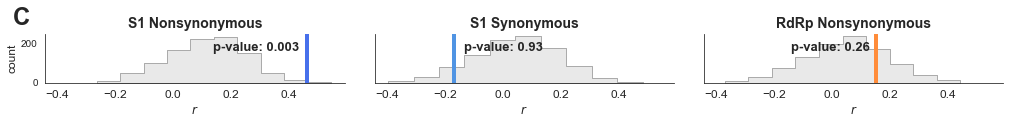

In [17]:
plot_fig1c(['randomization_results/growth_rate_stats/growth_stats_50it.json', 
            'randomization_results/growth_rate_stats/growth_stats_50itmore.json', 
            'randomization_results/growth_rate_stats/growth_stats_200its.json', 
            'randomization_results/growth_rate_stats/growth_stats_400its.json', 
            'randomization_results/growth_rate_stats/growth_stats_300its.json'], filename='plots/fig1c_r_stats.png')

Now find pvalues for correlations between logistic growth rate and mutation accumulation in other genes. 

This generates the histograms and pvalues for Figure 1 Supplement 2.

In [24]:
def plot_fig1_supp_3(data_files_main, data_files_supp, filename=None):

    to_plot = pd.DataFrame(columns = ['data', 'iteration', 'gene', 'nonsyn_syn', 'r_value'])
    
    for data_file in data_files_supp:
        with open(data_file) as json_file:
            data = json.load(json_file)
            df = pd.DataFrame(data['growth_rate_stats'])
            to_plot = pd.concat([to_plot, df])

    
    for data_file in data_files_main:
        with open(data_file) as json_file:
            data = json.load(json_file)
            df = pd.DataFrame(data['growth_rate_stats'])
            to_plot = pd.concat([to_plot, df])
    
    with open('randomization_results/growth_rate_stats/growth_stats_observed.json') as observed_json:
        data_observed = json.load(observed_json)
        to_plot_observed = pd.DataFrame(data_observed['growth_rate_stats'])

    
    # categories of mutations to plot
    # tuples are (gene, nonsyn/syn, color for empirical data)
    subplot_categories = [('S1', 'nonsyn', "#4770eb"), ('S2', 'nonsyn', '#1238aa'), 
                          ('RdRp', 'nonsyn', "#ff8c3a"), ('N', 'nonsyn', '#419D78'), 
                          ('M', 'nonsyn', '#a2d9c3'), ('ORF7a', 'nonsyn', '#7c5295'),
                          ('Nsp6', 'nonsyn', "#c35100"), ('Nsp4', 'nonsyn', "#ffc59c")]
    # dictionary to convert labels to more readable labels
    readable_labels = {'nonsyn': 'Nonsynonymous', 'syn': 'Synonymous'}

    # initialize plot
    fig, axes = plt.subplots(4,2, figsize=(7,3), sharey=True, sharex=True)
    plt.tight_layout()
    sns.set_style("white")
    
    
    for i, ax in enumerate(axes.flat):
        expected = to_plot[(to_plot['gene']==subplot_categories[i][0]
                           )&(to_plot['nonsyn_syn']==subplot_categories[i][1])]
        
        num_iterations = len(expected)

        # plot a histogram of all expected R values
        ax = sns.histplot(data=expected, 
                          x='r_value', color = "#ABABAB",
                          element = 'step',alpha=0.25,
                          bins=10, stat='count', ax=ax)
        observed_r = to_plot_observed[(to_plot_observed['gene']==subplot_categories[i][0]
                                     )&(to_plot_observed['nonsyn_syn']==subplot_categories[i][1]
                                       )]['r_value'].values[0]
        # add line to show empirical R value
        ax.axvline(x=observed_r, color = subplot_categories[i][2], linewidth=4)
        # find pvalue
        pvalue= len(expected[expected['r_value']>observed_r])/num_iterations
        # amount to offset the position that the pvalue is printed
        offset = {0:-0.02, 1: 0.12, 2: 0.10, 3:0.08, 4: 0.08, 5:0.0, 6:0.08, 7:0.08}
        if pvalue < 0.005:
            pvalue = '< 0.005'
            ax.annotate(f'p-value: {pvalue}', xy=((observed_r+offset[i]), 0.65), 
                         xycoords='axes fraction',ha='left', size=11, fontweight='bold')
        else:
            ax.annotate(f'p-value: {round(pvalue, 2)}', xy=((observed_r+offset[i]), 0.65), 
                         xycoords='axes fraction',ha='left', size=11, fontweight='bold')
#         ax.set_title(f'{subplot_categories[i][0]} {readable_labels[subplot_categories[i][1]]}', 
#                      fontsize = 14, fontweight='bold')
#         ax.set_xlabel('$r$', fontsize=12)
        ax.set_ylabel('')
        plt.setp(ax.get_yticklabels(), visible=False)
#         ax.tick_params(axis='x', which='major', labelsize=10)


    
    for i, ax in enumerate(axes.flat):
        ax.set_ylabel('')
        ax.set_xlabel('')
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)

    
    
    sns.despine(left=False, bottom=False)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    

    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    
    

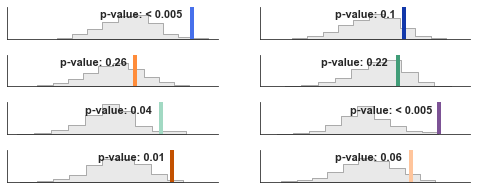

In [29]:
plot_fig1_supp_3(['randomization_results/growth_rate_stats/growth_stats_50it.json', 
            'randomization_results/growth_rate_stats/growth_stats_50itmore.json', 
            'randomization_results/growth_rate_stats/growth_stats_200its.json', 
            'randomization_results/growth_rate_stats/growth_stats_400its.json', 
            'randomization_results/growth_rate_stats/growth_stats_300its.json'], 
                 ['randomization_results/growth_rate_stats/growth_stats-supp_100its.json', 
                  'randomization_results/growth_rate_stats/growth_stats-supp_150its.json', 
                  'randomization_results/growth_rate_stats/growth_stats-supp_250its.json', 
                  'randomization_results/growth_rate_stats/growth_stats-supp_300its.json', 
                  'randomization_results/growth_rate_stats/growth_stats-supp_200itsmore.json',     
                 'randomization_results/growth_rate_stats/growth_stats-other_orfs_10its.json', 
                 'randomization_results/growth_rate_stats/growth_stats-other_orfs_100its.json', 
                 'randomization_results/growth_rate_stats/growth_stats-other_orfs_200its.json', 
                 'randomization_results/growth_rate_stats/growth_stats-other_orfs_300its.json',
                  'randomization_results/growth_rate_stats/growth_stats-other_orfs_250its.json',
                 'randomization_results/growth_rate_stats/growth_stats-other_nsps_10its.json', 
                 'randomization_results/growth_rate_stats/growth_stats-other_nsps_100its.json',
                 'randomization_results/growth_rate_stats/growth_stats-other_nsps_200its.json', 
                 'randomization_results/growth_rate_stats/growth_stats-other_nsps_300its.json', 
                 'randomization_results/growth_rate_stats/growth_stats-other_nsps_250its.json', 
                  'randomization_results/growth_rate_stats/growth_stats-other_nsps_150its.json'], 
                filename = 'plots/fig1_supp2stats_notitles.png')